In [1]:
import plot
from scipy.special import logit
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.proba.pickle', 'rb') as f:
        shap_values_a, shap_values_b, shap_values_a_vs_b, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


## Generate Explanations

Now we define the functions to be explained:

In [4]:
predict_proba_a = lambda X: clf_a.predict_proba(X)[:, 1]
predict_proba_b = lambda X: clf_b.predict_proba(X)[:, 1]

And now we calculate SHAP values for each function:

In [5]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(predict_proba_a)
shap_values_b = explain(predict_proba_b)

shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data

feature_order = np.flip(shap_values_a_vs_b.abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.proba.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b, shap_values_a_vs_b, feature_order), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.1 s, sys: 124 ms, total: 6.22 s
Wall time: 7.14 s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

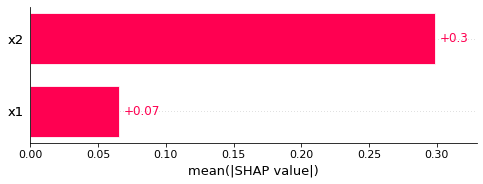

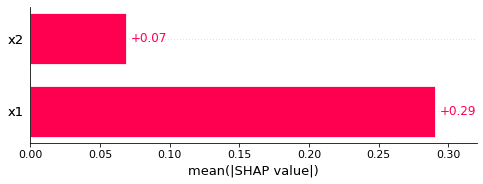

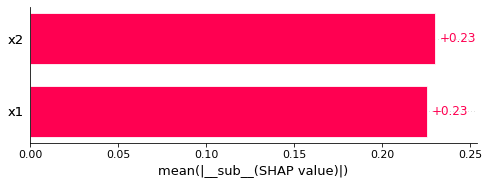

In [16]:
shap.plots.bar(shap_values_a, order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_b, order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_a_vs_b, order=feature_order, max_display=n_features)

### SHAP Value Distribution

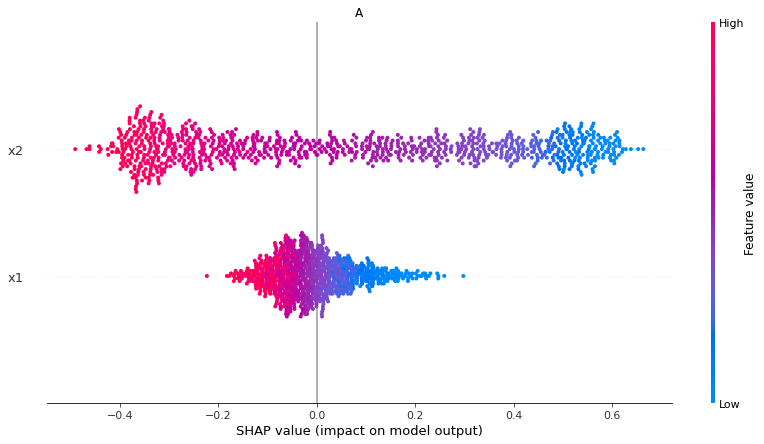

In [7]:
plot.shap_beeswarm(shap_values_a, 'A', order=feature_order, max_display=n_features)

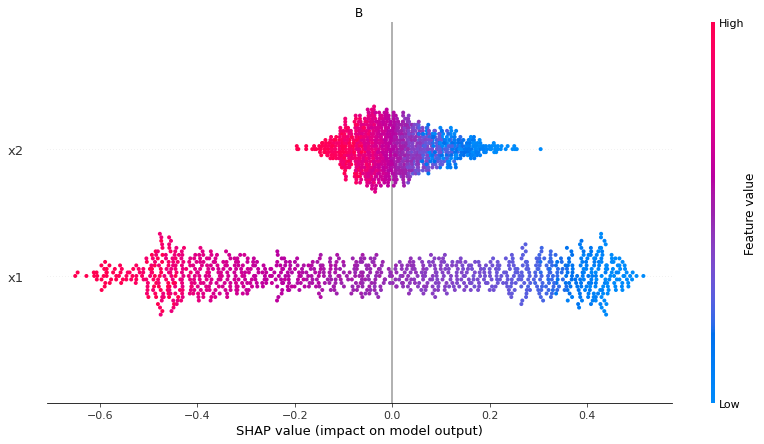

In [8]:
plot.shap_beeswarm(shap_values_b, 'B', order=feature_order, max_display=n_features)

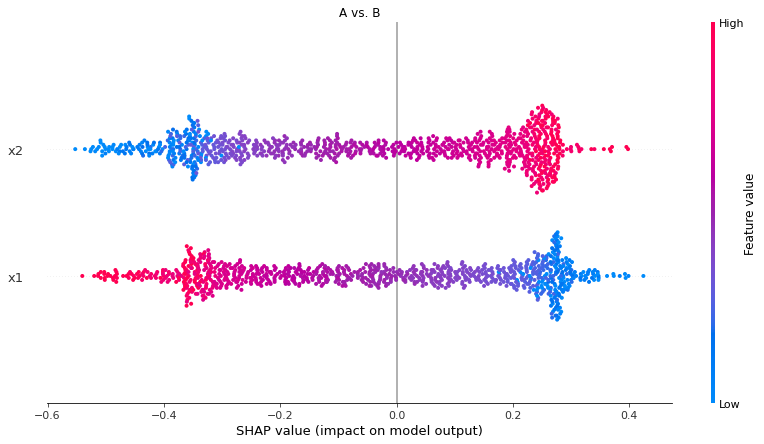

In [9]:
plot.shap_beeswarm(shap_values_a_vs_b, 'A vs. B', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

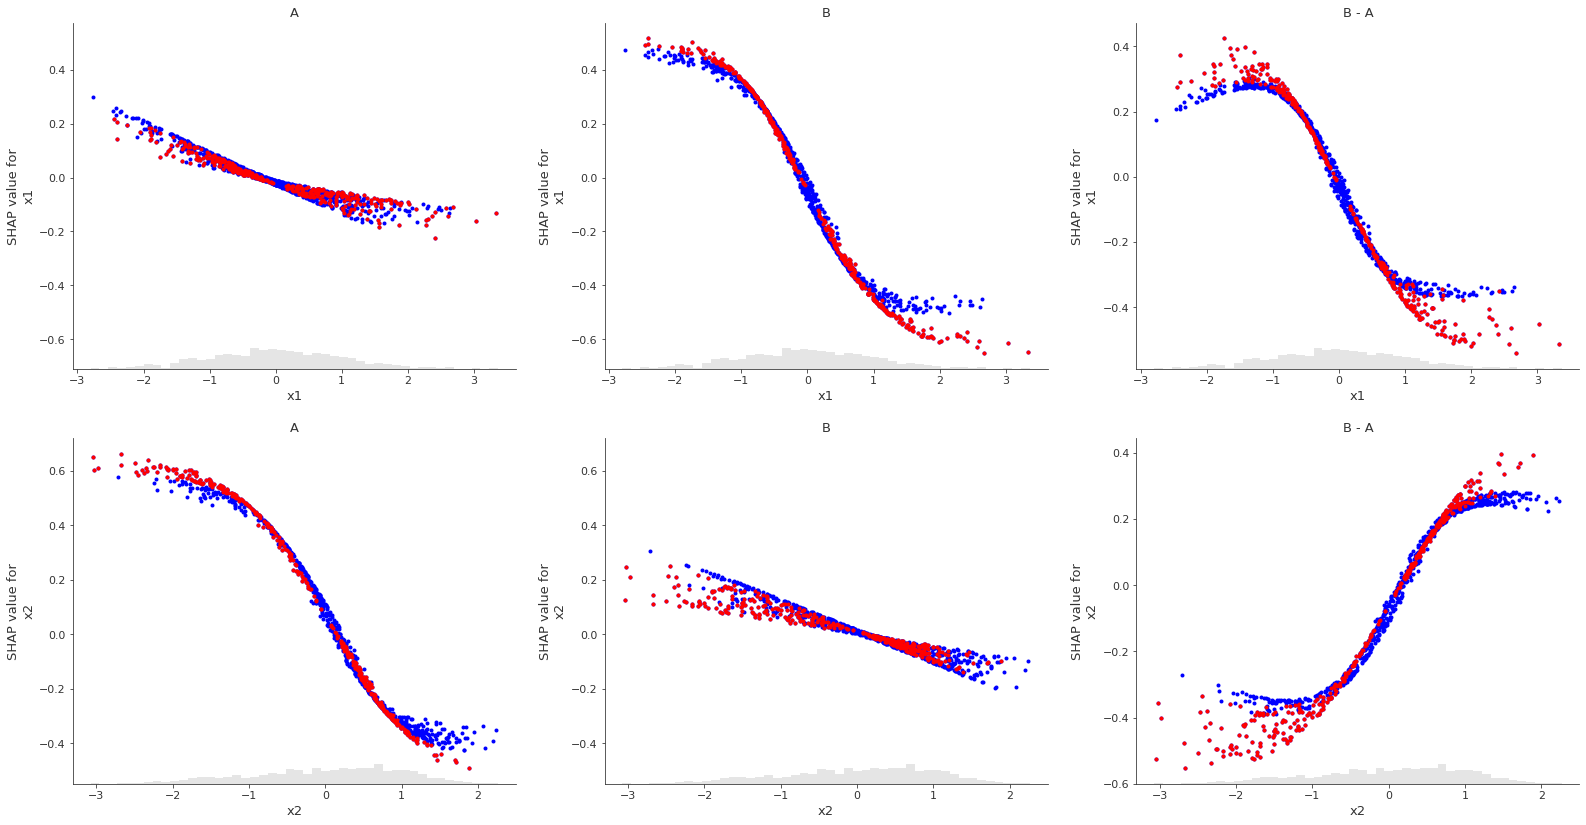

In [10]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[:, feature], title='A', ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[pred_a != pred_b, feature], title='A', ax=ax1, color='red',  hist=False, show=False)
    shap.plots.scatter(shap_values_b[:, feature], title='B', ax=ax2, color='blue', dot_size=16, show=False)
    shap.plots.scatter(shap_values_b[pred_a != pred_b, feature], title='B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[:, feature], title='B - A', ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[pred_a != pred_b, feature], title='B - A', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [11]:
idx_diff = indices[pred_a != pred_b]
idx_equal = indices[pred_a == pred_b]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

In [12]:
order = plot.shap_force(shap_values_a_vs_b[idx_diff], 'A vs. B')
plot.shap_force(shap_values_a[idx_diff], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_diff], 'B', ordering=order);

In [13]:
order = plot.shap_force(shap_values_a_vs_b[idx_equal], 'A vs. B')
plot.shap_force(shap_values_a[idx_equal], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_equal], 'B', ordering=order);

### Hierarchically Clustered SHAP Values

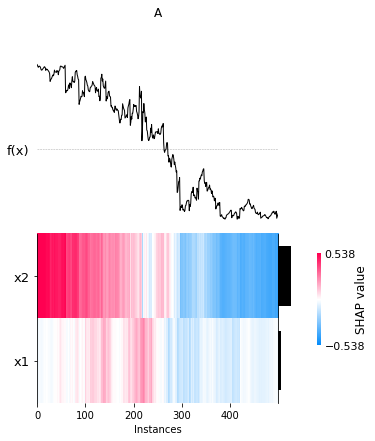

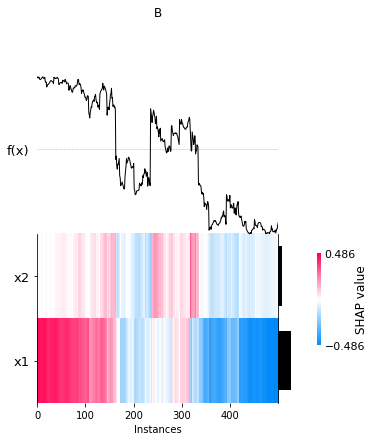

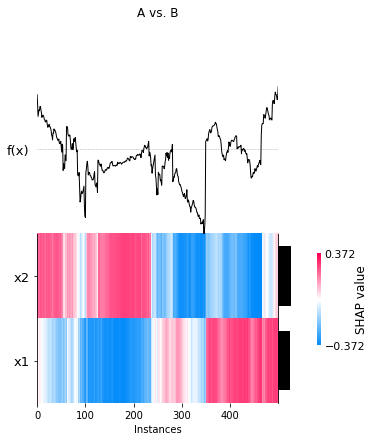

In [14]:
plot.shap_heatmap(shap_values_a[idx_equal], 'A', feature_order)
plot.shap_heatmap(shap_values_b[idx_equal], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[idx_equal], 'A vs. B', feature_order)

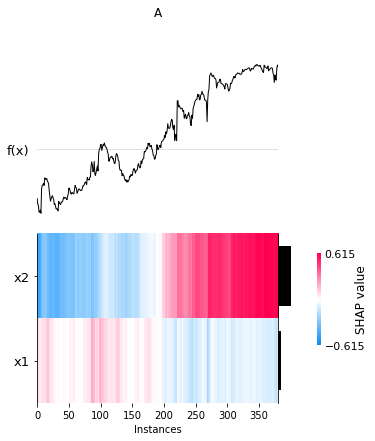

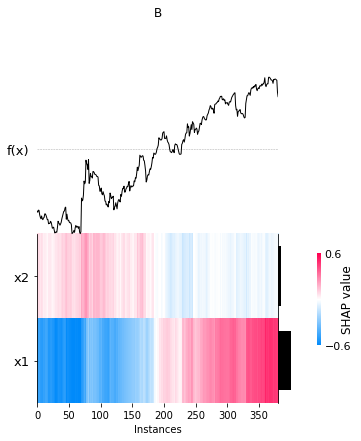

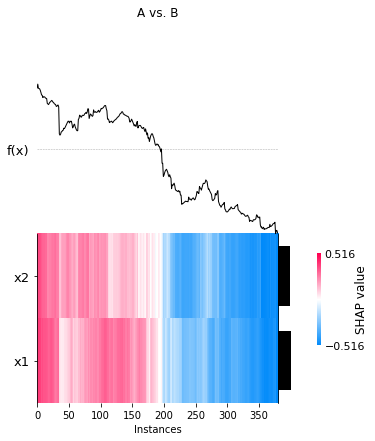

In [15]:
plot.shap_heatmap(shap_values_a[idx_diff], 'A', feature_order)
plot.shap_heatmap(shap_values_b[idx_diff], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[idx_diff], 'A vs. B', feature_order)